In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#lendo o dataset
df = pd.read_csv('data/stats.csv')

#define a ordem do dataset como sendo crescente de acordo com o ano
df = df.sort_values(by='Year')

#reseta os índices do dataset e deleta a coluna de índices antigos
df = df.reset_index(drop=True)

#deleta a segunda coluna
df = df.drop(df.columns[0], axis=1)

#deleta a coluna "Season", porque todas são iguais
df = df.drop('Season', axis=1)

#criando uma coluna de índice de país (com base na coluna "NOC")
df['NNOC'] = pd.Categorical(df['NOC'])
df['NNOC'] = df['NNOC'].cat.codes

df.head()

,Name,Sex,Age,Team,NOC,Games,Year,City,Sport,Event,Medal,NNOC
0,Paul Neumann (-Newman),M,20.0,Austria,AUT,1896 Summer,1896,Athina,Swimming,Swimming Men's 500 metres Freestyle,Gold,13
1,"Friedrich Adolf ""Fritz"" Traun",M,20.0,Great Britain/Germany,GER,1896 Summer,1896,Athina,Tennis,Tennis Men's Doubles,Gold,80
2,"Friedrich Adolf ""Fritz"" Traun",M,20.0,Germany,GER,1896 Summer,1896,Athina,Athletics,Athletics Men's 100 metres,NaN,80
3,"Friedrich Adolf ""Fritz"" Traun",M,20.0,Germany,GER,1896 Summer,1896,Athina,Athletics,Athletics Men's 800 metres,NaN,80
4,Efstathios Khorafas,M,NaN,Greece,GRE,1896 Summer,1896,Athina,Swimming,Swimming Men's 100 metres Freestyle,NaN,82


In [5]:
#mostrando uma tabela com a tradução de o que significa cada NNOC com base no NOC
NOC = df[['NOC', 'NNOC']]
NOC = NOC.drop_duplicates()
NOC = NOC.sort_values(by='NNOC')
NOC = NOC.reset_index(drop=True)
NOC.head()

,NOC,NNOC
0,AFG,0
1,AHO,1
2,ALB,2
3,ALG,3
4,AND,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237673 entries, 0 to 237672
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Name    237673 non-null  object 
 1   Sex     237673 non-null  object 
 2   Age     228484 non-null  float64
 3   Team    237673 non-null  object 
 4   NOC     237673 non-null  object 
 5   Games   237673 non-null  object 
 6   Year    237673 non-null  int64  
 7   City    237673 non-null  object 
 8   Sport   237673 non-null  object 
 9   Event   237673 non-null  object 
 10  Medal   36537 non-null   object 
 11  NNOC    237673 non-null  int16  
dtypes: float64(1), int16(1), int64(1), object(9)
memory usage: 20.4+ MB


In [7]:
import ipywidgets as widgets
from IPython.display import display

#criando um slider para selecionar o intervalo de anos
year_slider = widgets.IntRangeSlider(
    value=[1896, 2020],
    min=1896,
    max=2020,
    step=4,
    description='Intervalo de ano:',
    continuous_update=False
)

#criando um dropdown para selecionar a quantidade de países a serem mostrados
top_countries_dropdown = widgets.Dropdown(
    options=[5, 10, 15],
    value=10,
    description='Número de países:',
    disabled=False,
)

#criando a função que irá atualizar o gráfico de acordo com os valores selecionados
def update_plot(year_interval, top_countries):
    filtered_df1 = df[(df['Year'] >= year_interval[0]) & (df['Year'] <= year_interval[1])]
    filtered_df = filtered_df1.groupby('NOC')['Medal'].count().nlargest(top_countries)
    filtered_df = pd.DataFrame({'NOC': filtered_df.index, 'Medal': filtered_df.values})

    #adicionando no dataframe quantas das medalhas são de ouro, de prata e de bronze
    gold = []
    silver = []
    bronze = []
    for noc in filtered_df['NOC']:
        gold.append(len(filtered_df1[(filtered_df1['NOC'] == noc) & (filtered_df1['Medal'] == 'Gold')]))
        silver.append(len(filtered_df1[(filtered_df1['NOC'] == noc) & (filtered_df1['Medal'] == 'Silver')]))
        bronze.append(len(filtered_df1[(filtered_df1['NOC'] == noc) & (filtered_df1['Medal'] == 'Bronze')]))
    filtered_df['Gold'] = gold
    filtered_df['Silver'] = silver
    filtered_df['Bronze'] = bronze

    #define os dados que serão plotados
    medal_counts = filtered_df[['Gold', 'Silver', 'Bronze']]
    countries = filtered_df['NOC']

    #largura da barra
    bar_w = 0.7

    #posição da barra
    r = np.arange(len(countries))

    #criando a ordem de plotagem
    plt.figure(figsize=(14, 8))
    plt.barh(r, medal_counts['Bronze'], color='brown', height=bar_w, edgecolor='black', label='Bronze')
    plt.barh(r, medal_counts['Silver'], left=medal_counts['Bronze'], color='silver', height=bar_w, edgecolor='black', label='Silver')
    plt.barh(r, medal_counts['Gold'], left=medal_counts['Bronze'] + medal_counts['Silver'], color='gold', height=bar_w, edgecolor='black', label='Gold')

    #invertendo o eixo y (maior pro menor)
    plt.gca().invert_yaxis()

    #labels e título
    plt.xlabel('Número de Medalhas')
    plt.ylabel('Países')
    plt.yticks(r, countries)
    plt.title('Top ' + str(top_countries) + ' países com mais medalhas entre ' + str(year_interval[0]) + ' e ' + str(year_interval[1]))

    #definindo as coordenadas da tabela
    table_coords = [0.75, 0.3, 0.2, 0.4]

    #criando uma tabela
    table_data = [['País', 'Medalhas']] + [[country, medal_counts.loc[i].sum()] for i, country in enumerate(countries)]
    table = plt.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center', bbox=table_coords)

    #formata a tabela
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.5)

    #plotando
    plt.legend(['Bronze', 'Prata', 'Ouro'])
    plt.show()

#criando o output
output = widgets.interactive_output(update_plot, {'year_interval': year_slider, 'top_countries': top_countries_dropdown})

#mostrando os widgets
display(year_slider, top_countries_dropdown, output)

IntRangeSlider(value=(1896, 2020), continuous_update=False, description='Intervalo de ano:', max=2020, min=189…

Dropdown(description='Número de países:', index=1, options=(5, 10, 15), value=10)

Output()

In [8]:
#dataframe pros EUA
df_USA = df[df['NOC'] == 'USA']

#contando cada tipo de medalha por ano
df_medalsUSA = df_USA.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsUSA.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsUSA.fillna(0, inplace=True)

df_medalsUSA

,Year,Bronze,Gold,Silver
0,1896,2,11,7
1,1900,17,30,16
2,1904,125,128,141
3,1906,6,12,6
4,1908,15,34,16
5,1912,36,46,25
6,1920,38,111,45
7,1924,49,97,36
8,1928,17,47,24
9,1932,61,81,47


In [9]:
#dataframe para a Rússia
df_RUS = df[df['NOC'].isin(['RUS', 'EUN', 'URS', 'ROC'])]

#contando cada tipo de medalha por ano
df_medalsRUS = df_RUS.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsRUS.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsRUS.fillna(0, inplace=True)

df_medalsRUS.head()

,Year,Bronze,Gold,Silver
0,1908,0.0,1.0,2.0
1,1912,9.0,0.0,5.0
2,1952,19.0,36.0,62.0
3,1956,55.0,68.0,46.0
4,1960,45.0,61.0,63.0


In [10]:
#dataframe para a China
df_CHN = df[df['NOC'] == 'CHN']

#contando cada tipo de medalha por ano
df_medalsCHN = df_CHN.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsCHN.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsCHN.fillna(0, inplace=True)

df_medalsCHN.head()

,Year,Bronze,Gold,Silver
0,1984,37,24,13
1,1988,30,6,16
2,1992,19,18,45
3,1996,17,19,70
4,2000,17,39,23


In [11]:
#dataframe para a França
df_FRA = df[df['NOC'] == 'FRA']

#contando cada tipo de medalha por ano
df_medalsFRA = df_FRA.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsFRA.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsFRA.fillna(0, inplace=True)

df_medalsFRA.head()

,Year,Bronze,Gold,Silver
0,1896,2.0,5.0,4.0
1,1900,82.0,52.0,101.0
2,1904,0.0,0.0,2.0
3,1906,28.0,20.0,16.0
4,1908,23.0,12.0,5.0


In [12]:
#dataframe para o Reino Unido
df_GBR = df[df['NOC'] == 'GBR']

#contando cada tipo de medalha por ano
df_medalsGBR = df_GBR.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsGBR.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsGBR.fillna(0, inplace=True)

df_medalsGBR.head()

,Year,Bronze,Gold,Silver
0,1896,3.0,3.0,3.0
1,1900,15.0,59.0,34.0
2,1904,0.0,1.0,1.0
3,1906,8.0,9.0,22.0
4,1908,90.0,147.0,131.0


In [13]:
#dataframe para o Brasil
df_BRA = df[df['NOC'] == 'BRA']

#contando cada tipo de medalha por ano
df_medalsBRA = df_BRA.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsBRA.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsBRA.fillna(0, inplace=True)

df_medalsBRA.head()

,Year,Bronze,Gold,Silver
0,1920,5.0,1.0,1.0
1,1948,10.0,0.0,0.0
2,1952,2.0,1.0,0.0
3,1956,0.0,1.0,0.0
4,1960,13.0,0.0,0.0


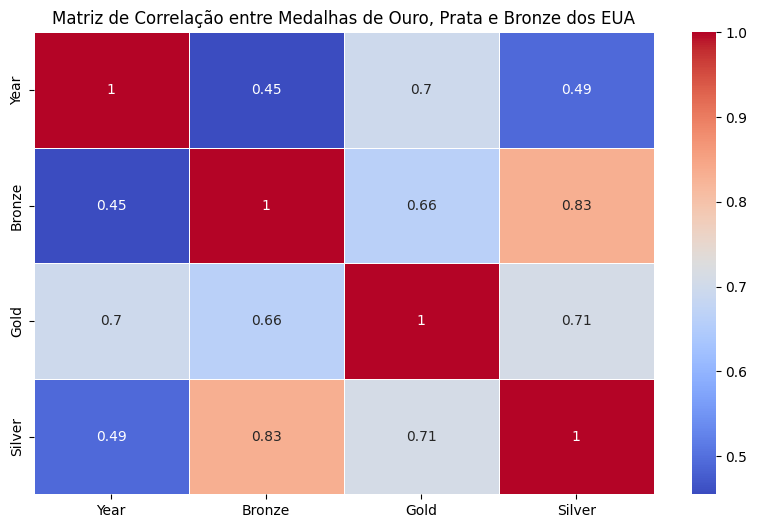

In [14]:
#montando a matriz de correlação dos EUA somente para mostrar que há correlação entre as variáveis
correlation = df_medalsUSA.corr()

#plotando a matriz de correlação
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação entre Medalhas de Ouro, Prata e Bronze dos EUA')
plt.show()

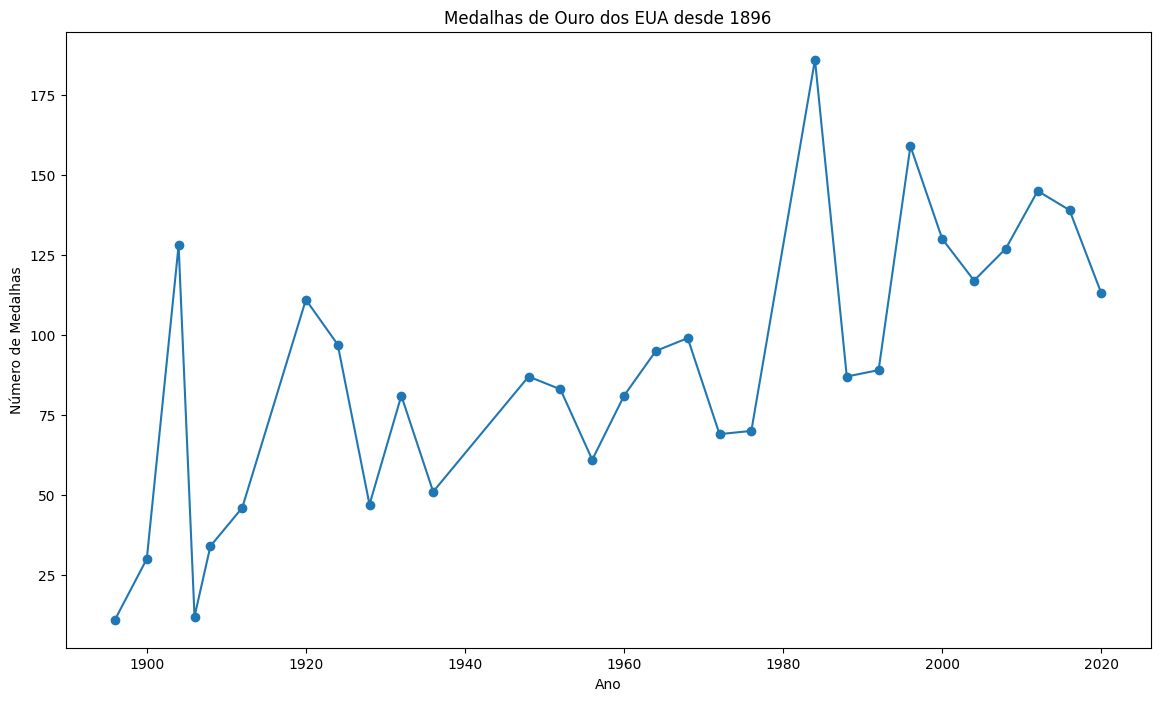

In [15]:
#line plot of gold medals of USA since 1896:
plt.figure(figsize=(14, 8))
plt.plot(df_medalsUSA['Year'], df_medalsUSA['Gold'], marker='o')
plt.title('Medalhas de Ouro dos EUA desde 1896')
plt.xlabel('Ano')
plt.ylabel('Número de Medalhas')
plt.show()

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

In [17]:
# Extract the relevant data for USA from the df_USA DataFrame
usa_medals = df_medalsUSA[['Year', 'Gold', 'Silver', 'Bronze']].copy()

# Set the 'Year' column as the index
usa_medals.set_index('Year', inplace=True)

# Create a time series for each medal type
gold_ts = usa_medals['Gold']
silver_ts = usa_medals['Silver']
bronze_ts = usa_medals['Bronze']

# Assuming your time series data is stored in the variable `time_series_data`
# Use auto_arima to determine the best ARIMA model
model = auto_arima(bronze_ts, seasonal=False)

# Get the coefficients of the ARIMA model
coefficients = model.get_params()

# Print the coefficients
print(coefficients)

{'maxiter': 50, 'method': 'lbfgs', 'order': (3, 1, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}


In [18]:
# Extract the relevant data for USA from the df_USA DataFrame
usa_medals = df_medalsUSA[['Year', 'Gold', 'Silver', 'Bronze']].copy()

# Set the 'Year' column as the index
usa_medals.set_index('Year', inplace=True)

# Create a time series for each medal type
gold_ts = usa_medals['Gold']
silver_ts = usa_medals['Silver']
bronze_ts = usa_medals['Bronze']

# Fit the ARIMA model for each medal type
gold_model = SARIMAX(gold_ts, order=(4, 1, 0), seasonal_order=(1, 1, 1, 19)).fit()
silver_model = SARIMAX(silver_ts, order=(0, 1, 1), seasonal_order=(1, 1, 1, 19)).fit()
bronze_model = SARIMAX(bronze_ts, order=(3, 1, 0), seasonal_order=(1, 1, 1, 19)).fit()

# Predict the medals for USA for the next 4 Olympic Games
predicted_gold = gold_model.predict(start=len(gold_ts), end=len(gold_ts) + 4)
predicted_silver = silver_model.predict(start=len(silver_ts), end=len(silver_ts) + 4)
predicted_bronze = bronze_model.predict(start=len(bronze_ts), end=len(bronze_ts) + 4)

# Create a DataFrame with the predictions
predicted_medals = pd.DataFrame({'Year': [2024, 2028, 2032, 2036, 2040],
                                 'Gold': predicted_gold.values,
                                 'Silver': predicted_silver.values,
                                 'Bronze': predicted_bronze.values})

# Set the 'Year' column as the index
predicted_medals.set_index('Year', inplace=True)

# Concatenate the original time series with the predicted time series
usa_medals = pd.concat([usa_medals, predicted_medals])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21265D+00    |proj g|=  1.02126D+00


/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  1.83362D+00    |proj g|=  8.80143D-02

At iterate   10    f=  1.73675D+00    |proj g|=  1.74857D-01

At iterate   15    f=  1.67013D+00    |proj g|=  2.85660D-02

At iterate   20    f=  1.66666D+00    |proj g|=  3.50670D-03

At iterate   25    f=  1.66661D+00    |proj g|=  3.92343D-03

At iterate   30    f=  1.66661D+00    |proj g|=  9.62434D-04

At iterate   35    f=  1.66659D+00    |proj g|=  5.20789D-03

At iterate   40    f=  1.66646D+00    |proj g|=  3.31141D-03

At iterate   45    f=  1.66639D+00    |proj g|=  1.00684D-03

At iterate   50    f=  1.66632D+00    |proj g|=  9.33631D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


At iterate   20    f=  1.70133D+00    |proj g|=  7.34716D-04

At iterate   25    f=  1.70131D+00    |proj g|=  1.22165D-03

At iterate   30    f=  1.70130D+00    |proj g|=  2.94681D-04

At iterate   35    f=  1.70129D+00    |proj g|=  8.82082D-04

At iterate   40    f=  1.70128D+00    |proj g|=  7.26344D-04

At iterate   45    f=  1.70127D+00    |proj g|=  9.20822D-04

At iterate   50    f=  1.70124D+00    |proj g|=  2.12882D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     62      1     0     0   2.129D-03   1.701D+00
  F =   1.7012449640754777     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


At iterate   10    f=  1.53137D+00    |proj g|=  2.38940D-02

At iterate   15    f=  1.52953D+00    |proj g|=  1.31364D-04

At iterate   20    f=  1.52951D+00    |proj g|=  2.05868D-03

At iterate   25    f=  1.52947D+00    |proj g|=  8.14532D-04

At iterate   30    f=  1.52946D+00    |proj g|=  2.45021D-04

At iterate   35    f=  1.52946D+00    |proj g|=  6.49634D-04

At iterate   40    f=  1.52942D+00    |proj g|=  1.75448D-03

At iterate   45    f=  1.52897D+00    |proj g|=  2.34026D-03

At iterate   50    f=  1.52869D+00    |proj g|=  5.49296D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62   

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `

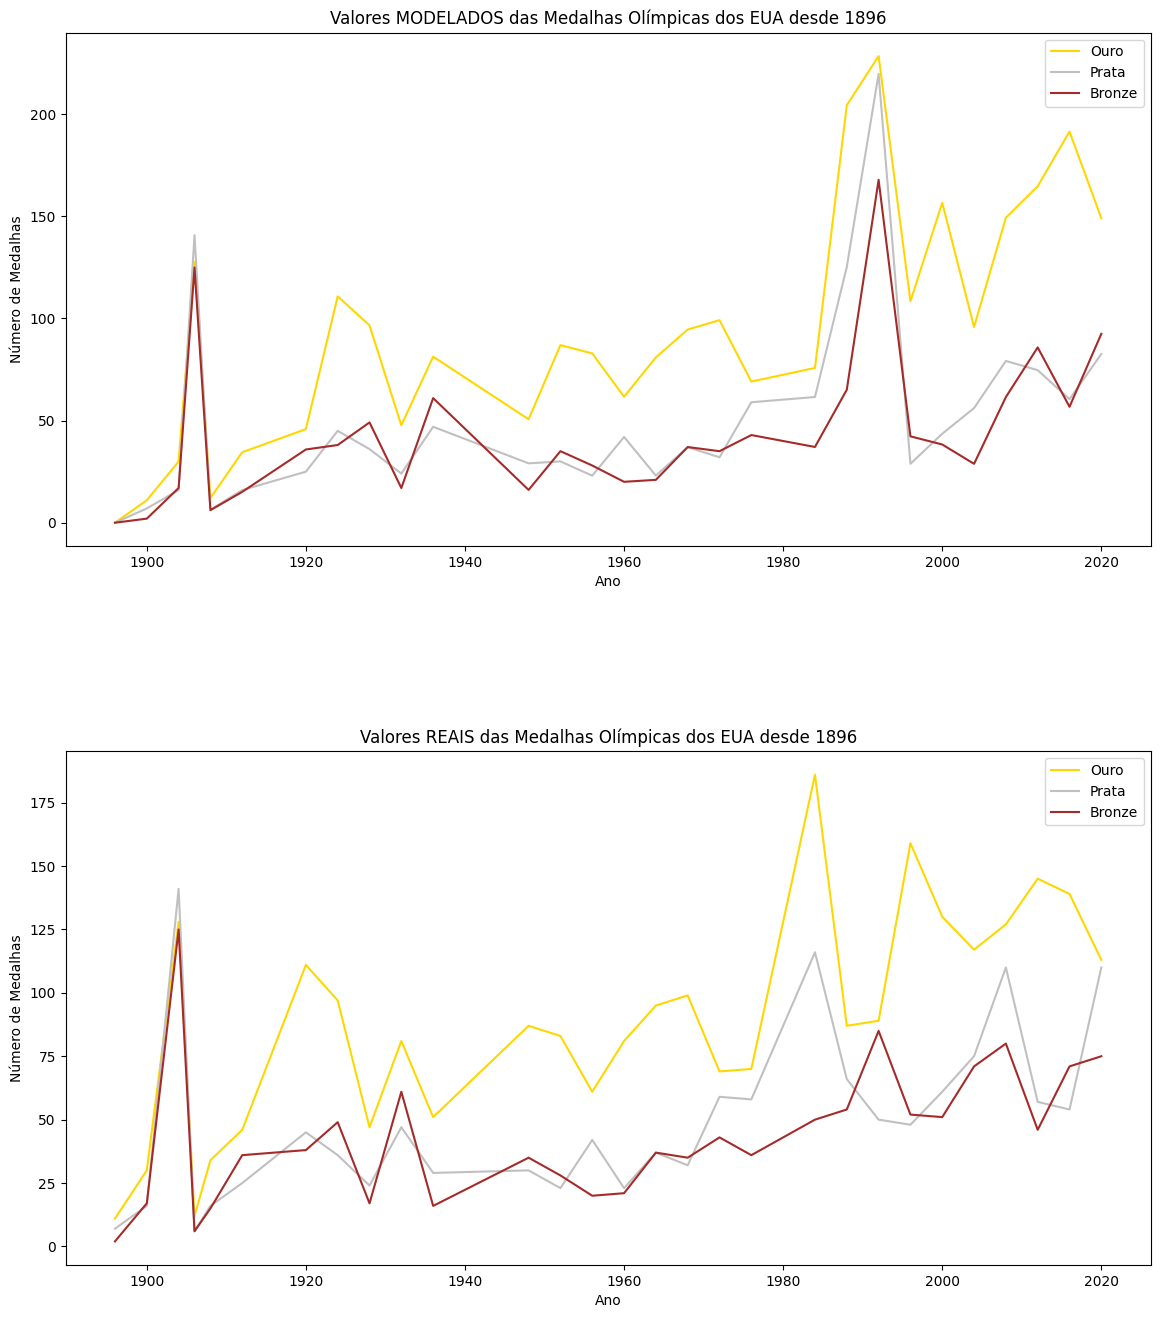

In [19]:
predicted_goldMSE = gold_model.predict(start=0, end=28)
predicted_silverMSE = silver_model.predict(start=0, end=28)
predicted_bronzeMSE = bronze_model.predict(start=0, end=28)

df_predicted_goldMSE = predicted_goldMSE.to_frame()
df_predicted_goldMSE.columns = ['Gold']

df_predicted_silverMSE = predicted_silverMSE.to_frame()
df_predicted_silverMSE.columns = ['Silver']

df_predicted_bronzeMSE = predicted_bronzeMSE.to_frame()
df_predicted_bronzeMSE.columns = ['Bronze']

df_predicted_medalsMSE = pd.concat([df_predicted_goldMSE, df_predicted_silverMSE, df_predicted_bronzeMSE], axis=1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Plot the predicted medals using df_predicted_medalsMSE
ax1.plot(df_predicted_medalsMSE['Gold'], label='Gold', color='gold')
ax1.plot(df_predicted_medalsMSE['Silver'], label='Silver', color='silver')
ax1.plot(df_predicted_medalsMSE['Bronze'], label='Bronze', color='brown')
ax1.set_title('Valores MODELADOS das Medalhas Olímpicas dos EUA desde 1896')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Medalhas')
ax1.legend(['Ouro', 'Prata', 'Bronze'])

# Plot the actual medals using df_medalsUSA
ax2.plot(df_medalsUSA['Year'], df_medalsUSA['Gold'], label='Gold', color='gold')
ax2.plot(df_medalsUSA['Year'], df_medalsUSA['Silver'], label='Silver', color='silver')
ax2.plot(df_medalsUSA['Year'], df_medalsUSA['Bronze'], label='Bronze', color='brown')
ax2.set_title('Valores REAIS das Medalhas Olímpicas dos EUA desde 1896')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Número de Medalhas')
ax2.legend(['Ouro', 'Prata', 'Bronze'])

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Display the plot
plt.show()


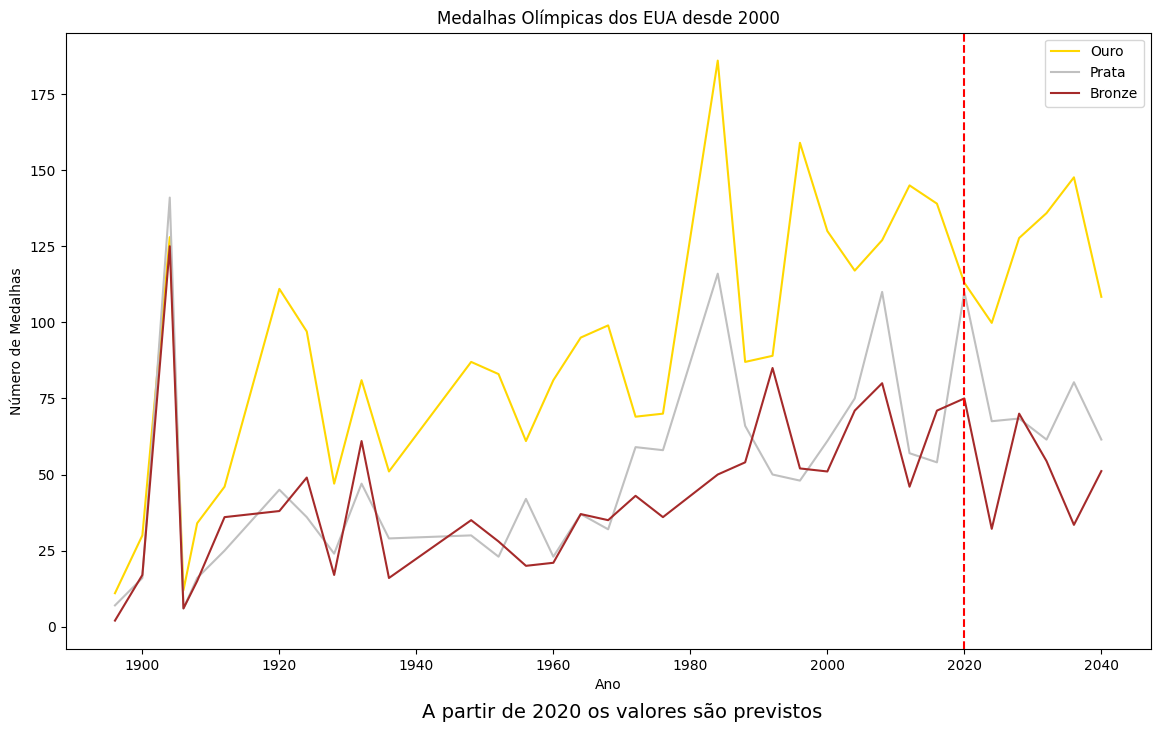

In [20]:
# Plot the time series
usa_medals_filtered = usa_medals[usa_medals.index >= 1896]

plt.figure(figsize=(14, 8))
plt.plot(usa_medals_filtered['Gold'], label='Gold', color='gold')
plt.plot(usa_medals_filtered['Silver'], label='Silver', color='silver')
plt.plot(usa_medals_filtered['Bronze'], label='Bronze', color='brown')
plt.title('Medalhas Olímpicas dos EUA desde 2000')
plt.xlabel('Ano')
plt.ylabel('Número de Medalhas')
plt.legend(['Ouro', 'Prata', 'Bronze'])
plt.axvline(x=2020, color='red', linestyle='--')
plt.text(1970, -30, 'A partir de 2020 os valores são previstos', ha='center', fontsize=14)

plt.show()


In [21]:
df_medalsUSA_train = df_medalsUSA[df_medalsUSA['Year'] <= 1988]

# Extract the relevant data for USA from the df_USA DataFrame
usa_medals = df_medalsUSA_train[['Year', 'Gold', 'Silver', 'Bronze']].copy()

# Set the 'Year' column as the index
usa_medals.set_index('Year', inplace=True)

# Create a time series for each medal type
gold_ts = usa_medals['Gold']
silver_ts = usa_medals['Silver']
bronze_ts = usa_medals['Bronze']

# Assuming your time series data is stored in the variable `time_series_data`
# Use auto_arima to determine the best ARIMA model
model = auto_arima(gold_ts, seasonal=False)

# Get the coefficients of the ARIMA model
coefficients = model.get_params()

# Print the coefficients
print(coefficients)

{'maxiter': 50, 'method': 'lbfgs', 'order': (4, 1, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}


In [57]:
# Extract the relevant data for USA from the df_USA DataFrame
usa_medals = df_medalsUSA_train[['Year', 'Gold', 'Silver', 'Bronze']].copy()

# Set the 'Year' column as the index
usa_medals.set_index('Year', inplace=True)

# Create a time series for each medal type
gold_ts = usa_medals['Gold']
silver_ts = usa_medals['Silver']
bronze_ts = usa_medals['Bronze']

# Fit the ARIMA model for each medal type
gold_model = SARIMAX(gold_ts, order=(4, 1, 0), seasonal_order=(1, 0, 1, 19)).fit()
silver_model = SARIMAX(silver_ts, order=(0, 1, 1), seasonal_order=(1, 0, 1, 19)).fit()
bronze_model = SARIMAX(bronze_ts, order=(3, 1, 0), seasonal_order=(1, 0, 1, 19)).fit()

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.77259D+00    |proj g|=  1.88383D-01

At iterate    5    f=  4.73006D+00    |proj g|=  9.32169D-03

At iterate   10    f=  4.72967D+00    |proj g|=  1.22969D-02

At iterate   15    f=  4.72781D+00    |proj g|=  5.10554D-03

At iterate   20    f=  4.72684D+00    |proj g|=  5.91515D-03

At iterate   25    f=  4.72453D+00    |proj g|=  1.08640D-02

At iterate   30    f=  4.72424D+00    |proj g|=  9.89947D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(


At iterate   10    f=  4.70612D+00    |proj g|=  1.52061D-04

At iterate   15    f=  4.70612D+00    |proj g|=  2.44018D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   2.440D-06   4.706D+00
  F =   4.7061176741720345     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34814D+00    |proj g|=  1.25884D+00

At iterate    5    f=  4.50812D+00    |proj g|=  1.58640D-01

At iter

In [73]:
predicted_goldMSE = gold_model.predict(start=0, end=32)
predicted_silverMSE = silver_model.predict(start=0, end=32)
predicted_bronzeMSE = bronze_model.predict(start=0, end=32)

df_predicted_goldMSE = predicted_goldMSE.to_frame()
df_predicted_goldMSE.columns = ['Gold']

df_predicted_silverMSE = predicted_silverMSE.to_frame()
df_predicted_silverMSE.columns = ['Silver']

df_predicted_bronzeMSE = predicted_bronzeMSE.to_frame()
df_predicted_bronzeMSE.columns = ['Bronze']

df_predicted_medalsMSE = pd.concat([df_predicted_goldMSE, df_predicted_silverMSE, df_predicted_bronzeMSE], axis=1)

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index be

In [75]:
df_predicted_medalsMSE['Year'] = df_medalsUSA['Year']

df_predicted_medalsMSE.loc[29, 'Year'] = 2024
df_predicted_medalsMSE.loc[30, 'Year'] = 2032
df_predicted_medalsMSE.loc[31, 'Year'] = 2036
df_predicted_medalsMSE.loc[32, 'Year'] = 2040

df_trainUSA = df_medalsUSA[df_medalsUSA['Year'] <= 1988]

df_trainUSA = pd.concat([df_trainUSA, df_predicted_medalsMSE[df_predicted_medalsMSE['Year'] >= 1992]], ignore_index=True)

df_trainUSA.set_index('Year', inplace=True)

df_trainUSA


,Bronze,Gold,Silver
Year,,,
1896.0,2.000000,11.000000,7.000000
1900.0,17.000000,30.000000,16.000000
1904.0,125.000000,128.000000,141.000000
1906.0,6.000000,12.000000,6.000000
1908.0,15.000000,34.000000,16.000000
1912.0,36.000000,46.000000,25.000000
1920.0,38.000000,111.000000,45.000000
1924.0,49.000000,97.000000,36.000000
1928.0,17.000000,47.000000,24.000000


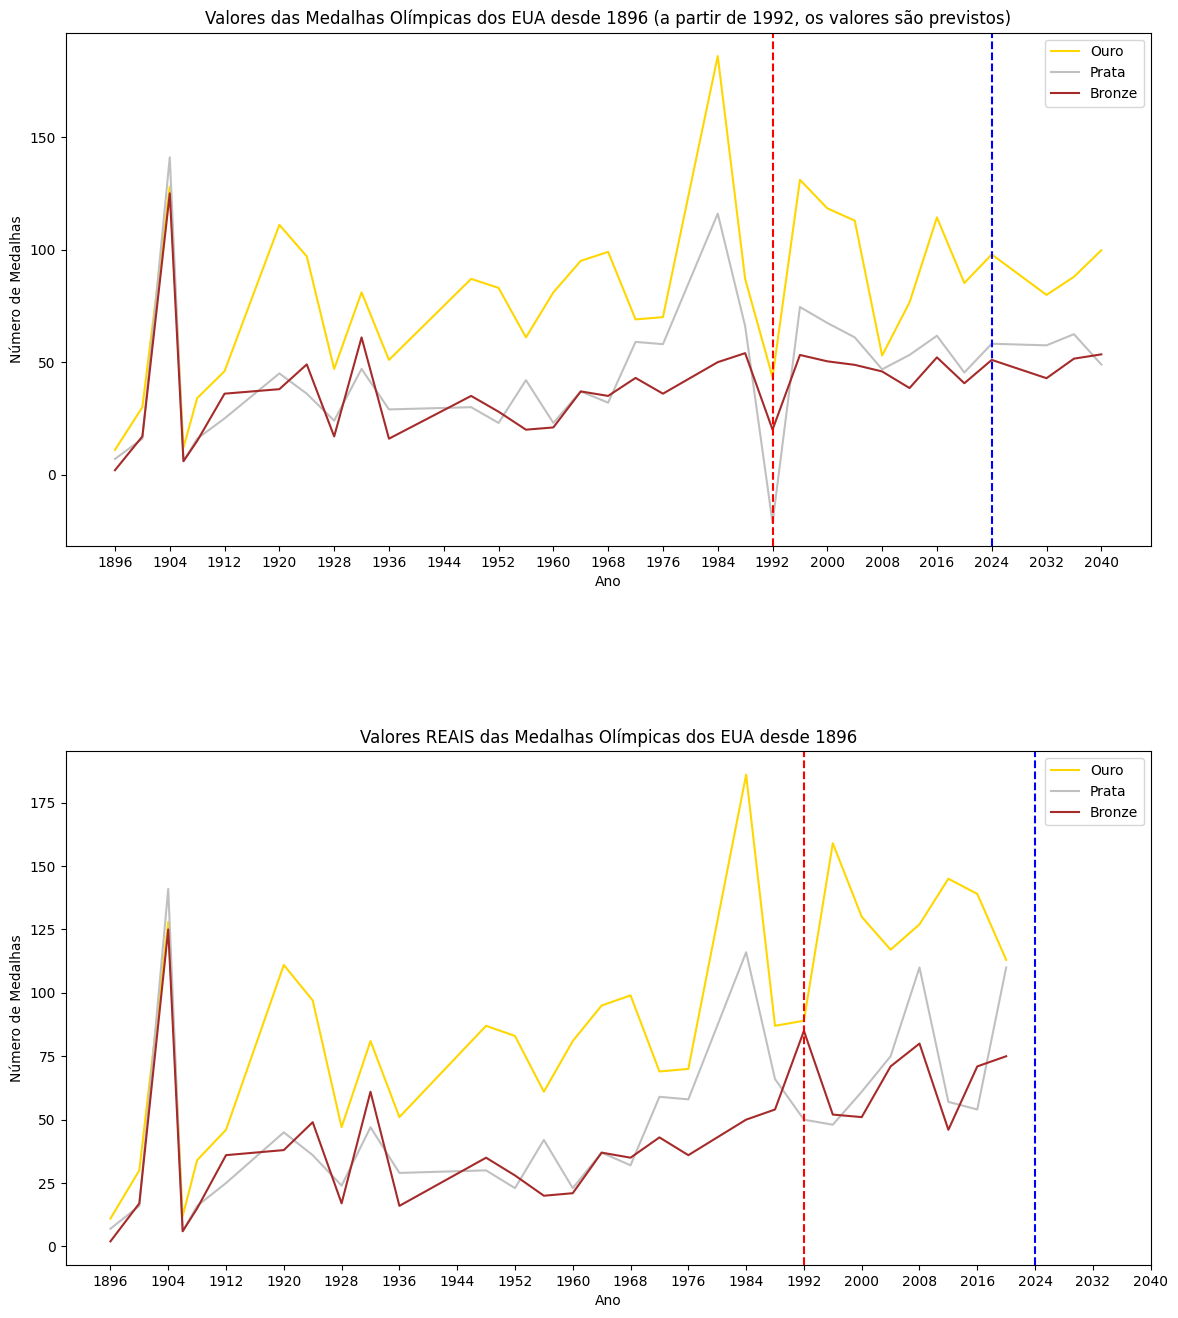

In [86]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

x_ticks = list(range(1896, 2041, 4))

# Plot the predicted medals using df_predicted_medalsMSE
ax1.plot(df_trainUSA['Gold'], label='Gold', color='gold')
ax1.plot(df_trainUSA['Silver'], label='Silver', color='silver')
ax1.plot(df_trainUSA['Bronze'], label='Bronze', color='brown')
ax1.set_title('Valores das Medalhas Olímpicas dos EUA desde 1896 (a partir de 1992, os valores são previstos)')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Medalhas')
ax1.legend(['Ouro', 'Prata', 'Bronze'])
ax1.set_xticks(range(1896, 2041, 8))
ax1.axvline(x=1992, color='red', linestyle='--')
ax1.axvline(x=2024, color='blue', linestyle='--')

# Plot the actual medals using df_medalsUSA
ax2.plot(df_medalsUSA['Year'], df_medalsUSA['Gold'], label='Gold', color='gold')
ax2.plot(df_medalsUSA['Year'], df_medalsUSA['Silver'], label='Silver', color='silver')
ax2.plot(df_medalsUSA['Year'], df_medalsUSA['Bronze'], label='Bronze', color='brown')
ax2.set_title('Valores REAIS das Medalhas Olímpicas dos EUA desde 1896')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Número de Medalhas')
ax2.set_xticks(range(1896, 2041, 8))
ax2.legend(['Ouro', 'Prata', 'Bronze'])
ax2.axvline(x=1992, color='red', linestyle='--')
ax2.axvline(x=2024, color='blue', linestyle='--')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Display the plot
plt.show()
